<a href="https://colab.research.google.com/github/nitinranjansharma/EVA5B2/blob/main/s9/s9_workflow_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import numpy as np
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F


In [ ]:
import albumentations as A
import torchvision.transforms as transforms
import torch
from PIL import Image
from albumentations.pytorch import ToTensor
from plot_graph import plot_images, plot_graph
from utils import *
from gradcam.visualize import VisualizeCam

In [ ]:
## importing and transforming data
from read_inputs import read_transform_inputs
trainset, trainloader, testset, testloader, classes = read_transform_inputs()

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
  cat plane   dog plane


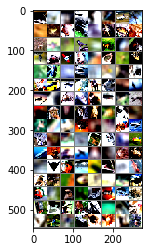

In [ ]:

import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [ ]:
## defining model

from define_model import ResNet
from define_model import BasicBlock
from define_model import Bottleneck
!pip install torchsummary
from torchsummary import summary

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

model = ResNet(BasicBlock, [2, 2, 2, 2]).to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1,

In [ ]:
##defining optimiser
from define_optim import optim_define
optimizer = optim_define(model)

In [ ]:
from train import train
from test import test
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR

epochs = 50
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler = OneCycleLR(optimizer, max_lr=0.1, epochs=epochs,
                       steps_per_epoch=len(trainloader))

def run(l1_decay=0.0, l2_decay=0.0):
  test_losses = []
  test_accs = []
  misclassified_imgs = []
  correct_imgs = []
  for epoch in range(epochs):
      print("EPOCH:", epoch+1)
      train(model, device, trainloader, criterion, optimizer, epoch, l1_decay, l2_decay, scheduler)
      test(model, device, testloader, criterion, classes, test_losses, test_accs,
           misclassified_imgs, correct_imgs, epoch==epochs-1)
  return test_losses, test_accs, misclassified_imgs, correct_imgs

# train and test the model
test_losses, test_accs, misclassified_imgs, correct_imgs = run(l1_decay=3e-6, l2_decay=1e-3)

EPOCH: 1
L2_loss=458.4736328125 L1_loss=108782.6015625 Loss=2.678879499435425 Batch_id=390 Accuracy=31.87: 100%|██████████| 391/391 [00:49<00:00,  7.95it/s]
Test set: Average loss: 0.0124, Accuracy: 4231/10000 (42.31%)

EPOCH: 2
L2_loss=457.6021728515625 L1_loss=107681.4140625 Loss=2.3946268558502197 Batch_id=390 Accuracy=40.26: 100%|██████████| 391/391 [00:49<00:00,  7.89it/s]
Test set: Average loss: 0.0130, Accuracy: 4345/10000 (43.45%)

EPOCH: 3
L2_loss=457.0129699707031 L1_loss=106343.4609375 Loss=2.1677918434143066 Batch_id=390 Accuracy=42.48: 100%|██████████| 391/391 [00:52<00:00,  7.45it/s]
Test set: Average loss: 0.0120, Accuracy: 4670/10000 (46.70%)

EPOCH: 4
L2_loss=456.6837463378906 L1_loss=104702.25 Loss=2.3088512420654297 Batch_id=390 Accuracy=44.48: 100%|██████████| 391/391 [00:49<00:00,  7.89it/s]
Test set: Average loss: 0.0107, Accuracy: 5227/10000 (52.27%)

EPOCH: 5
L2_loss=456.4142150878906 L1_loss=102897.0078125 Loss=2.0389835834503174 Batch_id=390 Accuracy=47.16: 10

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
GroundTruth:    cat  ship  ship plane


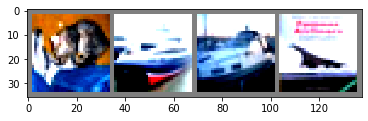

In [ ]:
## checking test images

dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images[:4]))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

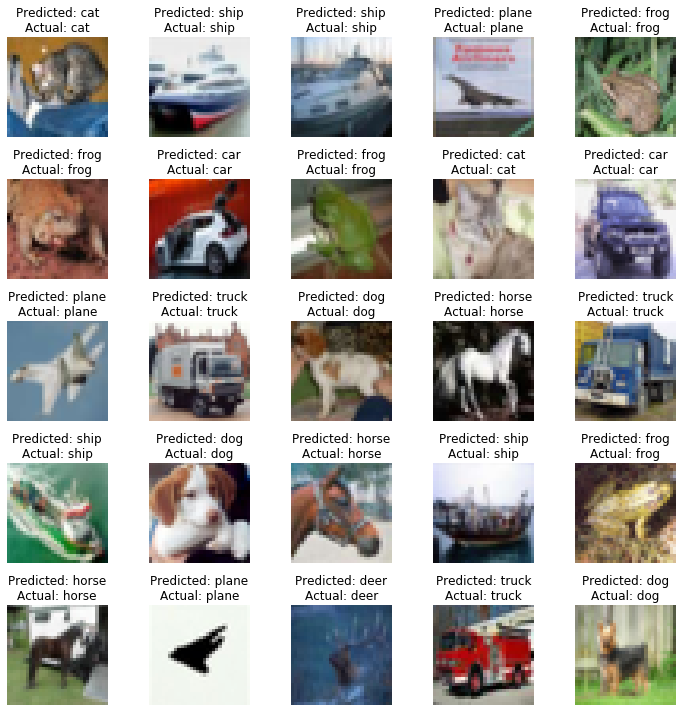

In [ ]:
## correct images
plot_images(correct_imgs, classes, "correct_imgs.png")

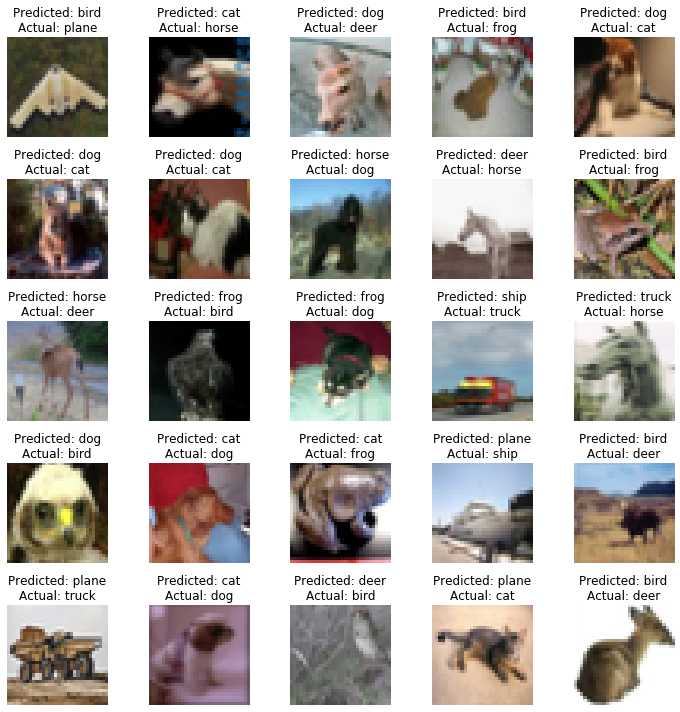

In [ ]:
plot_images(misclassified_imgs, classes, "misclassified_imgs.png")

In [ ]:
from accuracy_check import check_accuracy     
check_accuracy(testloader,device,model)

Accuracy of the network on the 10000 test images: 87 %


87.86

In [ ]:
torch.save(model,"model_2.sav")

In [ ]:
from gradcam.visualize import VisualizeCam

In [ ]:
target_layers = ["layer1","layer2","layer3","layer4"]
viz_cam = VisualizeCam(model,classes, target_layers)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

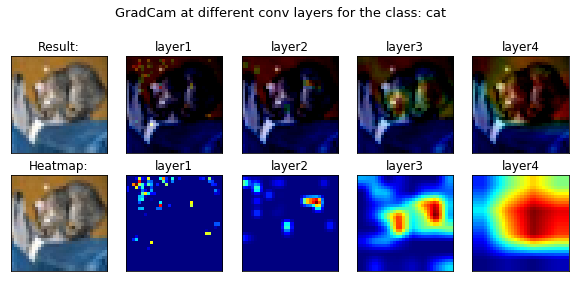

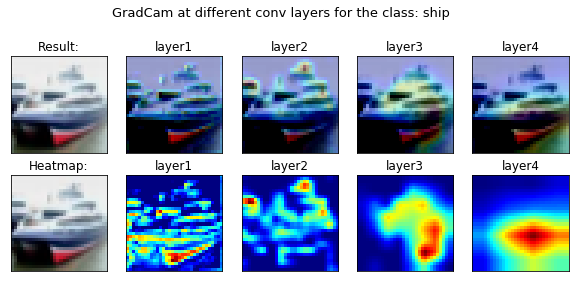

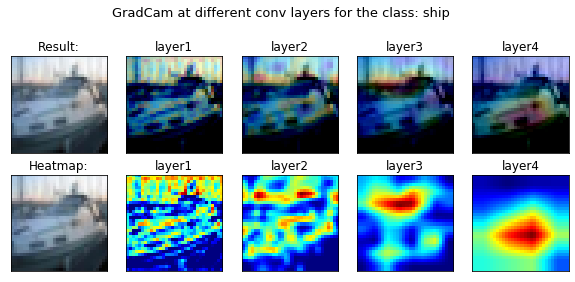

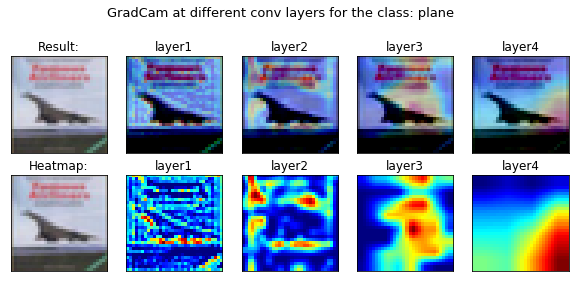

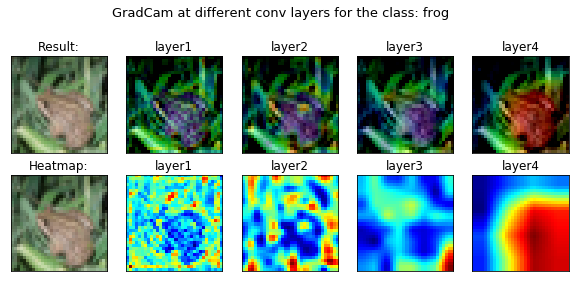

In [ ]:
##Correct Images
num_img = 5
correct_pred_imgs = []
for i in range(num_img):
  correct_pred_imgs.append(torch.as_tensor(correct_imgs[i]["img"]))
viz_cam(torch.stack(correct_pred_imgs), target_layers, metric="correct")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

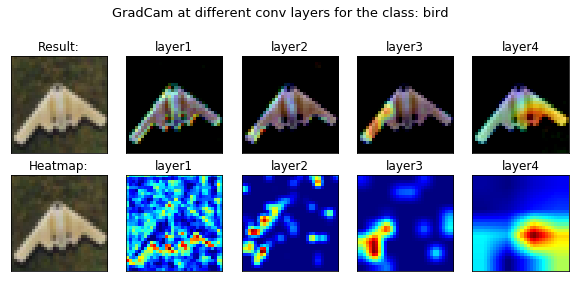

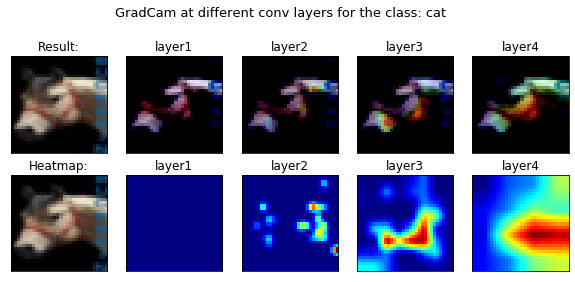

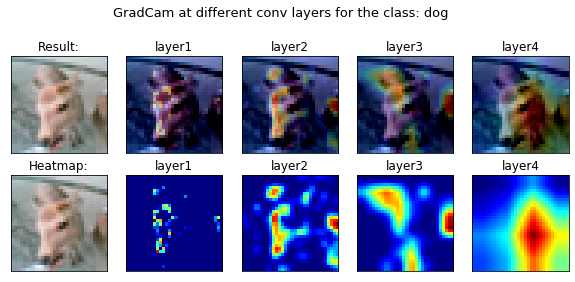

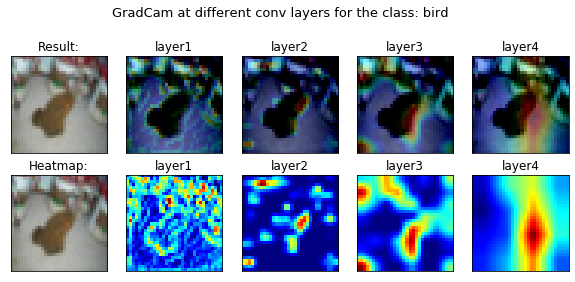

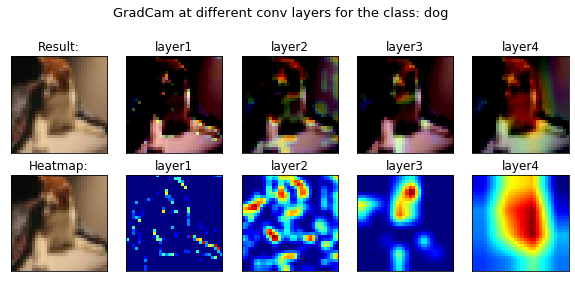

In [ ]:
##Misclassfied
incorrect_pred_imgs = []
for i in range(num_img):
  incorrect_pred_imgs.append(torch.as_tensor(misclassified_imgs[i]["img"]))
viz_cam(torch.stack(incorrect_pred_imgs), target_layers, metric="incorrect")